

---

**DEPENDENCIES**

---



In [ ]:
# !pip install mhyt
# !pip install urllib3
# !pip install mtcnn
# !pip install face_recognition
# !pip install cmake
# !pip install pytube



---

**IMPORTS**

---



In [ ]:
from IPython.display import HTML
import urllib3
import shutil
import dlib
import numpy as np
import cv2
import pandas as pd
import base64
from PIL import Image
import face_recognition
import cv2
import os, time
from base64 import b64encode
from mtcnn.mtcnn import MTCNN
from datetime import timedelta as td
from sklearn import cluster
from sklearn.decomposition import PCA
import os
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from skimage import measure
import face_recognition



---

**DOWNLOAD VIDEO**

---




In [ ]:
from mhyt import yt_download

yt_download("https://www.youtube.com/watch?v=gOFt-sz1T2A","download.mp4") 

overwrite file download.mp4
download https://www.youtube.com/watch?v=gOFt-sz1T2A in format mp4 to file download.mp4
[youtube] gOFt-sz1T2A: Downloading webpage
[download] Destination: download.mp4
[download] 100% of 16.95MiB in 00:00
Done downloading, now converting ...


In [ ]:
mp4 = open("download.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [ ]:
HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
""" % data_url)



---

**GET VIDEO FRAMES**

---



In [ ]:
def get_frames(fname):

  col_images = []
  cap = cv2.VideoCapture(fname)
  ret, frames = cap.read()

  if (cap.isOpened()== False): 
    print("Error opening video stream or file")

  while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
      col_images.append(frame)
    else: 
      break

  cap.release()
  cv2.destroyAllWindows()
  return col_images


col_images = get_frames('download.mp4')

In [ ]:
if not os.path.exists('output_images'):
  os.mkdir('output_images')



---

**KNOWN EMBEDDINGS FROM IMAGES**

---



In [ ]:
appearances = {}
known_face_encodings=[]
known_face_names = []

root = "/content/images/"
for filename in os.listdir(root):
  if filename.endswith(".PNG"):
    # print(filename)
    path = os.path.join(root, filename)
    filter_image = face_recognition.load_image_file(path)
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    filter_image = cv2.resize(filter_image, (0, 0), fx=5.00, fy=5.00)
    filter_face_encoding = face_recognition.face_encodings(filter_image)
    known_face_encodings.append(filter_face_encoding[0])
    known_face_names.append(filename.split('.')[0].lower())
    appearances[filename.split('.')[0].lower()] = []



---

**FACE DETECTION & IDENTIFICATION**

---



In [ ]:
user_appeared, face_locations, face_encodings, face_names = [], [], [], []
process_this_frame = True

detector = MTCNN()

def face():

    for i in range(0, len(col_images), 5): 

        f_num = i
        done = float(f_num / len(col_images) * 100)
        print('<> Frames processed: ' + str(round(done, 2)) + '% ')

        frame = col_images[i]
        process_this_frame = True

        small_frame = cv2.resize(frame, (0, 0), fx=1.0, fy=1.0) # keeping same size beacuse takes too much time.
        rgb_small_frame = small_frame[:, :, ::-1]
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        rgb_small_frame = cv2.filter2D(rgb_small_frame, -1, kernel)

        if process_this_frame:
            faces = detector.detect_faces(rgb_small_frame)
            face_locations = []

            for result in faces:
                loc = result['box']
                x, y, w, h = loc
                face_locations.append((y, x+w, y+h, x)) # (top, right, bottom, left)

            face_encodings = face_recognition.face_encodings(rgb_small_frame, known_face_locations=face_locations)
            face_names = []

            for i, face_encoding in enumerate(face_encodings):
                matches = face_recognition.compare_faces(known_face_encodings, face_encoding, tolerance = 0.52)
                name = ''
                if True in matches:
                    first_match_index = matches.index(True)
                    name = known_face_names[first_match_index]
                    # print(name)
                else:
                  new_img = frame.copy()
                  l, t, r, b = face_locations[i][3], face_locations[i][0], face_locations[i][1], face_locations[i][2]
                  t, r, b, l = int(t * 1), int(r * 1), int(b * 1), int(l * 1)
                  cv2.rectangle(new_img, (l, t), (r, b), (0, 0, 255), 2)
                  plt.ion()
                  plt.figure()
                  plt.imshow(new_img)
                  plt.show(block=False)
                  plt.close()
                  time.sleep(0.0005)
                  print('Now who is this?')
                  name = input()
                  time.sleep(0.0005)
                  known_face_names.append(name.lower())
                  known_face_encodings.append(face_encoding)

                if name in appearances:
                  appearances[name].append(f_num)
                else:
                  appearances[name] = [f_num]
                  
                face_names.append(name)
        process_this_frame = not process_this_frame

        for (top, right, bottom, left), name in zip(face_locations, face_names):
            top *= 1
            right *= 1
            bottom *= 1
            left *= 1
            top, right, bottom, left = int(top), int(right), int(bottom), int(left)
            font = cv2.FONT_HERSHEY_COMPLEX_SMALL
            cv2.rectangle(frame, (left-32, top-32), (right+32, bottom+32), (0, 0, 255), 2)
            cv2.putText(frame, name.split('.')[0], (left + 50, bottom - 50), font, 1.0, (0, 255, 0), 1)

        # WRITING RESULTING FRAMES TO NEW DIRECTORY
        cv2.imwrite('output_images/' + str(i)+'.png', frame) 
        # plt.ion()
        # plt.figure()
        # plt.imshow(frame)
        # plt.show(block=False)
        # plt.close()

face()

In [ ]:
print('Unique people: ', len(list(set(known_face_names))))

Unique people:  16




---

**CLUSTERING EMBEDDINGS**

---



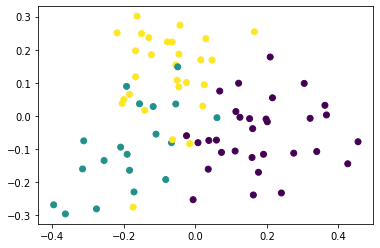

In [ ]:
X = known_face_encodings
pca = PCA(n_components=2)
result = pca.fit_transform(X)

kmeans = cluster.KMeans(n_clusters=3, random_state=0).fit(X)
plt.scatter(result[:, 0], result[:, 1], c=kmeans.labels_)



---

**GENERATING TABLE**

---



In [ ]:
names_embeddings = zip(known_face_names, known_face_encodings)
new_names, new_embeddings = [], []

for i, e in names_embeddings:
  if i in new_names:
    continue
  else:
    new_names.append(i)
    new_embeddings.append(e)

In [ ]:
new_times = []

for t in appearances:
  times = appearances[t]
  time_str = []
  x = 0
  till = x

  if len(times) == 0:
    new_times.append('')
  if len(times) == 1:
    time_str.append(str(td(seconds=times[0])) + ' - ' + str(td(seconds=times[0])))
    time_str = ', '.join(time_str)
    new_times.append(time_str)
  else:
    while x < len(times):
      prev = times[x]
      for y in range(x, len(times)):
        if times[y] - prev <= 25:
          till = y
          prev = times[y]
        else:
          till +=1
          time_str.append(str(td(seconds=times[x])) + ' - ' + str(td(seconds=times[x])))
          x += 1
      time_str.append(str(td(seconds=times[x])) + ' - ' + str(td(seconds=times[till])))
      x += till
    time_str = ', '.join(time_str)
    new_times.append(time_str)

In [ ]:
respective_time = []

for x in new_names:
  ind = new_names.index(x)
  respective_time.append(new_times[ind])

In [ ]:
table = pd.DataFrame({'Person': new_names, 'Sample face': new_embeddings, 'Time frame': respective_time})
print(table)

         Person  ...                                         Time frame
0         rafik  ...  0:14:25 - 0:14:25, 0:14:30 - 0:14:30, 0:14:35 ...
1        rodney  ...  0:52:55 - 0:52:55, 0:54:35 - 0:54:35, 0:54:45 ...
2          anna  ...                                                   
3    anastasiya  ...                                                   
4          igor  ...                                  1:25:50 - 1:25:50
5        daniel  ...  0:51:30 - 0:51:30, 0:51:35 - 0:51:35, 0:51:40 ...
6        zuhair  ...  0:06:45 - 0:06:45, 0:06:50 - 0:06:50, 0:06:55 ...
7   little girl  ...  0:13:50 - 0:13:50, 0:13:55 - 0:13:55, 0:14:05 ...
8         arina  ...  0:18:25 - 0:18:25, 0:18:30 - 0:18:30, 0:18:35 ...
9        andrey  ...                                                   
10         olya  ...                                                   
11        sasha  ...  0:52:10 - 0:52:10, 0:52:15 - 0:52:15, 0:53:30 ...
12       andres  ...                                            



---


**GENERATING OUTPUT VIDEO**

---





In [ ]:
img_array = []
path = '/content/output_images/'
output_frames = os.listdir(path)
output_frames = sorted(output_frames,key=lambda x: int(os.path.splitext(x)[0]))

for filename in output_frames:
    img = cv2.imread(os.path.join(path, filename))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 1, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()



---

**OUTPUT VIDEO** - ( If it doesn't play here, please download the video )

---



In [ ]:
mp4 = open("output.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [ ]:
HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
""" % data_url)